In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from pathlib import Path
import glob
import json
import seaborn as sns
from datetime import datetime
from aind_dynamic_foraging_basic_analysis.licks.lick_analysis import load_nwb
import re
from matplotlib import colormaps  

In [3]:
def assign_trials_to_kinematics(tongue_segmented, df_trials):
    """
    Adds 'time_in_session' and 'trial' columns to tongue_segmented dataframe
    by linking to df_trials using goCue timing.
    """
    # Normalize time
    tongue_segmented = tongue_segmented.copy()
    tongue_segmented['time_in_session'] = tongue_segmented['time_raw'] - df_trials['goCue_start_time_raw'].iloc[0]

    # Merge to get trial ID
    merged_df = pd.merge_asof(
        tongue_segmented,
        df_trials,
        left_on='time_in_session',
        right_on='goCue_start_time_in_session',
        direction='backward'
    )
    tongue_segmented['trial'] = merged_df['trial']
    
    return tongue_segmented


def assign_movements_to_licks(tongue_segmented, df_licks):
    """
    Assigns a movement_id to each lick based on whether the lick timestamp falls
    within the start and end of a segmented movement.
    """
    # Get movement start and end times
    movement_times = tongue_segmented.groupby("movement_id")["time_in_session"].agg(["min", "max"]).reset_index()
    movement_times.columns = ["movement_id", "movement_start_time", "movement_end_time"]

    # Find movement containing each lick
    def find_valid_movement_id(lick_time):
        match = movement_times[
            (movement_times["movement_start_time"] <= lick_time) & 
            (movement_times["movement_end_time"] >= lick_time)
        ]
        return match["movement_id"].iloc[0] if not match.empty else pd.NA

    df_licks = df_licks.copy()
    df_licks["nearest_movement_id"] = df_licks["timestamps"].apply(find_valid_movement_id).astype("Int64")
    
    return df_licks


def mark_licks_in_kinematics(tongue_segmented, licks_df, tolerance=0.01):
    """
    Marks frames in tongue_segmented that occur near lick timestamps in licks_df.
    
    Adds:
      - 'lick': boolean, True if within tolerance of any lick
      - 'lick_index': index from licks_df of the closest lick (or pd.NA)
    """
    tongue_segmented = tongue_segmented.copy()
    tongue_segmented['lick'] = False
    tongue_segmented['lick_index'] = pd.NA

    frame_times = tongue_segmented['time_in_session'].to_numpy()
    lick_times = licks_df['timestamps'].to_numpy()

    for i, lick_time in enumerate(lick_times):
        # Find frames within the time window
        diffs = np.abs(frame_times - lick_time)
        within_tolerance = diffs <= tolerance

        if within_tolerance.any():
            closest_frame = np.argmin(np.where(within_tolerance, diffs, np.inf))
            tongue_segmented.at[closest_frame, 'lick'] = True
            tongue_segmented.at[closest_frame, 'lick_index'] = i  # link back to licks_df

    return tongue_segmented




In [4]:
#Load kinematics data
from tongue_kinematics_utils import load_keypoints_from_csv, find_behavior_videos_folder, integrate_keypoints_with_video_time

#keypoints
LP_csv_path = '/root/capsule/data/BottomViewPylon1-MIB-2025-02-17/inference/behavior_716325_2024-05-31_10-31-14/bottom_camera.csv'

keypoint_dfs = load_keypoints_from_csv(LP_csv_path)

session_name = os.path.basename(os.path.dirname(LP_csv_path))
behavior_videos_folder = find_behavior_videos_folder(f'/root/capsule/data/{session_name}')

#get video timebase for keypoint dataframe
keypoint_dfs_trimmed, video_csv_trimmed = integrate_keypoints_with_video_time(
    os.path.join(behavior_videos_folder, 'bottom_camera.csv'), 
    keypoint_dfs
)

keypoints extracted: ['nose_tip', 'jaw', 'tongue_tip_right', 'tongue_tip_center', 'tongue_tip_left', 'pointer_finger_r', 'paw_wrist_r', 'pointer_finger_l', 'paw_wrist_l', 'spout_r', 'spout_l']
Video QC: Frame numbers are sequential with no gaps.
Video QC: Timing differences are within expected range.
keypoint_df trimmed from 2689719 to 2689718


In [5]:
#tongue kinematics processing and movement annotation
from tongue_kinematics_utils import mask_keypoint_data, kinematics_filter, segment_movements_trimnans
tongue_masked = mask_keypoint_data(keypoint_dfs_trimmed,'tongue_tip_center',confidence_threshold=0.90)
tongue_filtered = kinematics_filter(tongue_masked,cutoff_freq=50,filter_order=4)


Loading NWB from /root/capsule/data/foraging_nwb_bonsai/716325_2024-05-31_10-31-14.nwb


/opt/conda/lib/python3.9/site-packages/hdmf/spec/namespace.py:535: UserWarning: Ignoring cached namespace 'core' version 2.7.0 because version 2.8.0 is already loaded.
  warn("Ignoring cached namespace '%s' version %s because version %s is already loaded."


Timestamps are adjusted such that `_in_session` timestamps start at the first go cue
Timestamps are adjusted such that `_in_session` timestamps start at the first go cue


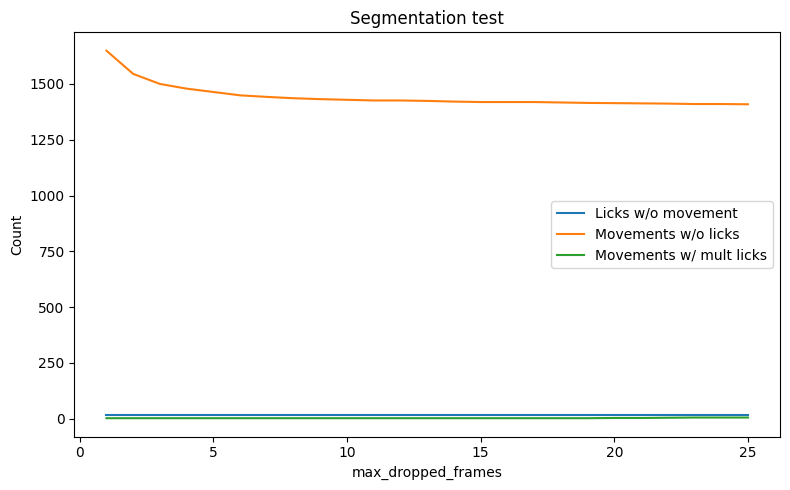

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from kinematics_nwb_utils import get_nwb_file
import aind_dynamic_foraging_data_utils.nwb_utils as nwb_utils
from aind_dynamic_foraging_basic_analysis.licks import annotation

# load your data once
nwb      = get_nwb_file(session_name)
nwb.df_events  = nwb_utils.create_events_df(nwb)
nwb.df_trials  = nwb_utils.create_df_trials(nwb)
nwb.df_licks   = annotation.annotate_licks(nwb)

results = []

for max_df in range(1, 26):
    # 1) segment, link trials, assign & mark licks
    tongue_seg = segment_movements_trimnans(tongue_filtered, max_dropped_frames=max_df)
    tongue_seg = assign_trials_to_kinematics(tongue_seg, nwb.df_trials)

    licks = nwb.df_licks.copy()
    licks = assign_movements_to_licks(tongue_seg, licks)
    tongue_seg = mark_licks_in_kinematics(tongue_seg, licks)

    # 2) lick‐level metrics
    total_licks = len(licks)
    licks_no_mov = licks['nearest_movement_id'].isna().sum()

    # 3) movement‐level DF
    movs = (
        tongue_seg
        .groupby('movement_id')
        .agg(
            lick_count    = ('lick','sum'),
            start_time    = ('time_in_session','min'),
            end_time      = ('time_in_session','max')
        )
        .reset_index()
    )
    movs['has_lick'] = movs['lick_count'] > 0

    # your original metrics
    multi_licks      = (movs['lick_count'] > 1).sum()
    total_licked_mov = movs['has_lick'].sum()
    no_lick_movs     = (~movs['has_lick']).sum()
    total_movs       = len(movs)

    # some extras you might find useful
    durations = movs['end_time'] - movs['start_time']    # in same units as time_in_session
    avg_dur   = durations.mean()
    med_dur   = durations.median()
    # count “tiny” segments (< 20 ms)
    tiny_movs  = (durations < 0.02).sum()

    results.append({
        'max_dropped_frames'      : max_df,
        'licks_without_movement'  : licks_no_mov,
        'pct_licks_unmatched'     : licks_no_mov/total_licks*100,
        'movements_mult_licks'    : multi_licks,
        'pct_multi_licked_mov'    : multi_licks/total_licked_mov*100 if total_licked_mov>0 else 0,
        'movements_without_licks' : no_lick_movs,
        'pct_movements_unlicked'  : no_lick_movs/total_movs*100,
        'total_movements'         : total_movs,
        'avg_movement_duration'   : avg_dur,
        'med_movement_duration'   : med_dur,
        'tiny_movements(<20ms)'   : tiny_movs,
    })

# turn into DataFrame
df = pd.DataFrame(results)

# ---- now plot ----
plt.figure(figsize=(8,5))
plt.plot(df.max_dropped_frames, df.licks_without_movement,    label='Licks w/o movement')
plt.plot(df.max_dropped_frames, df.movements_without_licks,   label='Movements w/o licks')
plt.plot(df.max_dropped_frames, df.movements_mult_licks,    label='Movements w/ mult licks')
plt.xlabel('max_dropped_frames')
plt.ylabel('Count')
plt.legend()
plt.title('Segmentation test')
plt.tight_layout()
plt.show()


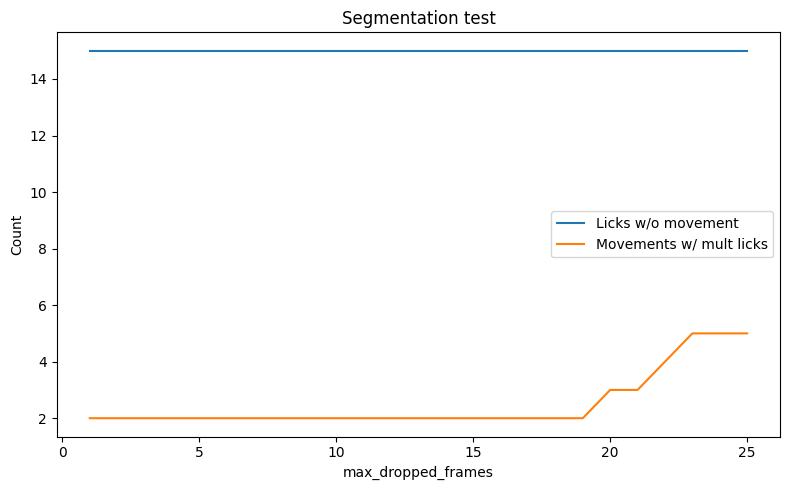

In [9]:
plt.figure(figsize=(8,5))
plt.plot(df.max_dropped_frames, df.licks_without_movement,    label='Licks w/o movement')
plt.plot(df.max_dropped_frames, df.movements_mult_licks,    label='Movements w/ mult licks')
plt.xlabel('max_dropped_frames')
plt.ylabel('Count')
plt.legend()
plt.title('Segmentation test')
plt.tight_layout()
plt.show()

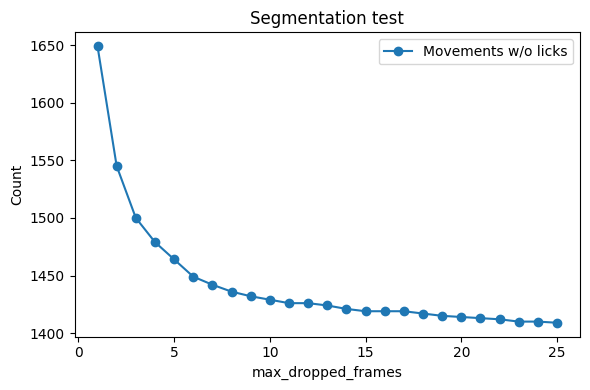

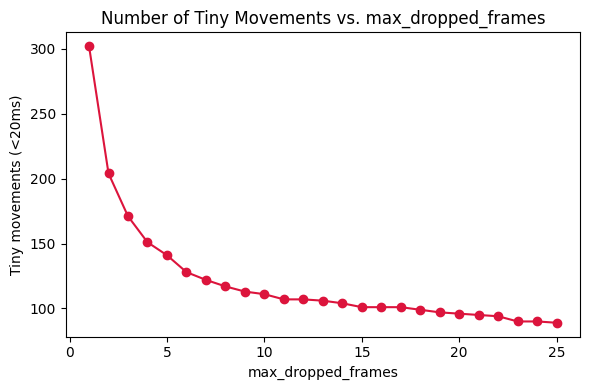

In [23]:
plt.figure(figsize=(6,4))
plt.plot(df.max_dropped_frames, df.movements_without_licks,   label='Movements w/o licks', marker='o')
plt.xlabel('max_dropped_frames')
plt.ylabel('Count')
plt.legend()
plt.title('Segmentation test')
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(df.max_dropped_frames, df['tiny_movements(<20ms)'], marker='o', color='crimson')
plt.xlabel('max_dropped_frames')
plt.ylabel('Tiny movements (<20ms)')
plt.title('Number of Tiny Movements vs. max_dropped_frames')
plt.tight_layout()
plt.show()

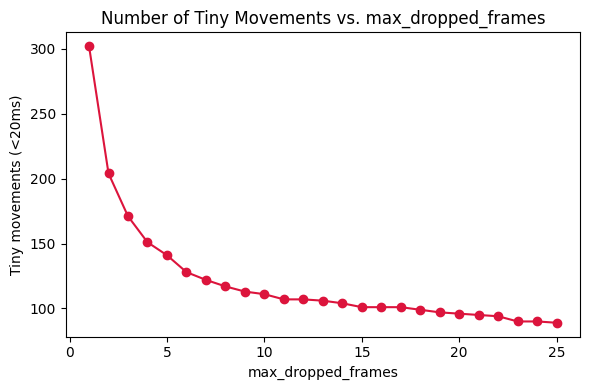

In [18]:
plt.figure(figsize=(6,4))
plt.plot(df.max_dropped_frames, df['tiny_movements(<20ms)'], marker='o', color='crimson')
plt.xlabel('max_dropped_frames')
plt.ylabel('Tiny movements (<20ms)')
plt.title('Number of Tiny Movements vs. max_dropped_frames')
plt.tight_layout()
plt.show()


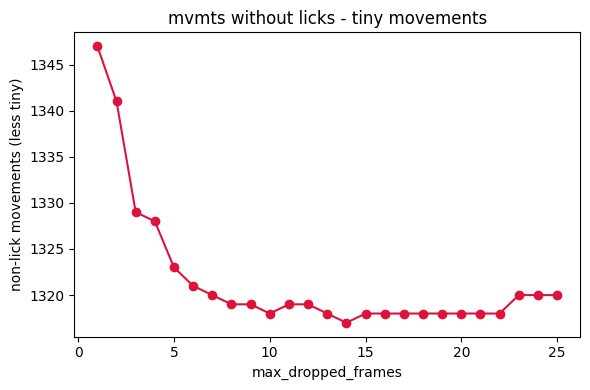

In [24]:
plt.figure(figsize=(6,4))
plt.plot(df.max_dropped_frames, df['movements_without_licks']-df['tiny_movements(<20ms)'], marker='o', color='crimson')
plt.xlabel('max_dropped_frames')
plt.ylabel('non-lick movements (less tiny)')
plt.title('mvmts without licks - tiny movements')
plt.tight_layout()
plt.show()